## James Griffin 
### Stat 536 
### Solar Pannel Time Series Report 


lab specs 

Solar Power
Solar power is an environmentally friendly alternative to fossil fuels. However, the amount of solar energy (as measured in kilowatt hours - kWh) can vary widely depending upon various factors such as season, angle of panels, direction of the sun, cloud cover, etc. Further, the solar panels themselves degrade over time such that the power output decreases over years of use. The dataset contains daily power generated from a single solar panel system on a single customer household. The power company would like to use the data to understand:

1. How the panels are degrading over time,
2. How many years till the panels have lost 50% of their power generating capability (on average)
3. Obtain projections of power for the next year.

In [94]:
#Importing stuff so Dr Heaton can outsource his return on his solar panels lol :) 

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import seaborn  as sns

In [95]:
# importing data 
data = pd.read_csv('../data/heaton_solar.csv')
data.head()
#ok so we just have 1 variable, kw/hour and the date, What dype is thte date

,Date,kwh
0,2017-01-01,23.05
1,2017-01-02,21.86
2,2017-01-03,23.10
3,2017-01-04,18.28
4,2017-01-05,12.30


In [96]:
type(data.Date[0]) #ok so this is a str, will probably have to change to date-time obj

str

##### Data processing 
I'm going to change th date from str to date time

In [97]:
dates = data.Date.tolist()
dt = pd.DatetimeIndex(dates).date.tolist()
data['dt'] = dt

###### DATA VISUALIZATION 


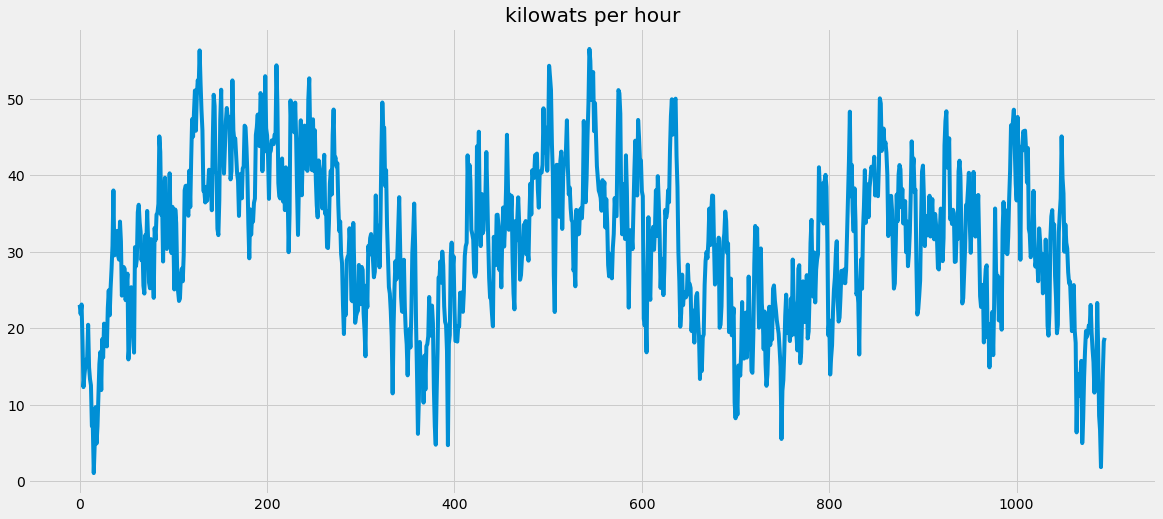

In [98]:
data.kwh.plot()
plt.title('kilowats per hour')
plt.show()


 We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

We used a seasonality of 365 days, cuz we have 3 years of data and I would argue that the number of kw/hour is very seassonal, and from above we can see the trend goes up from winter to summer and back down and cycles, so our period = 365 just hoping leap year was excluded lol 

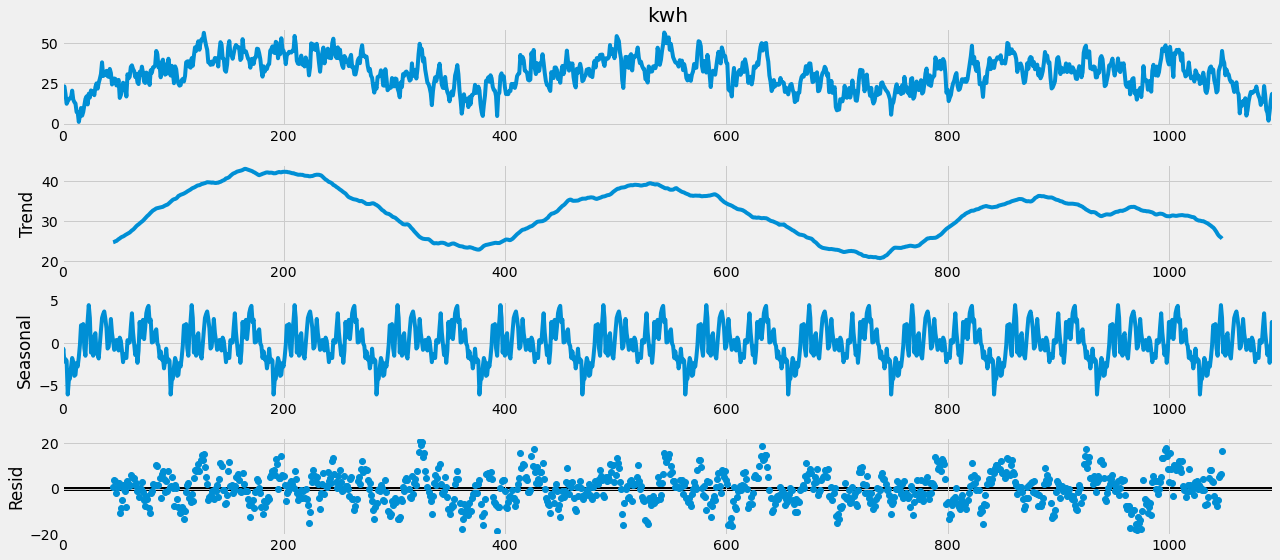

In [99]:
#decomposing into different aspects of the data 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.kwh, model='additive', period=93)
fig = decomposition.plot()
plt.show()

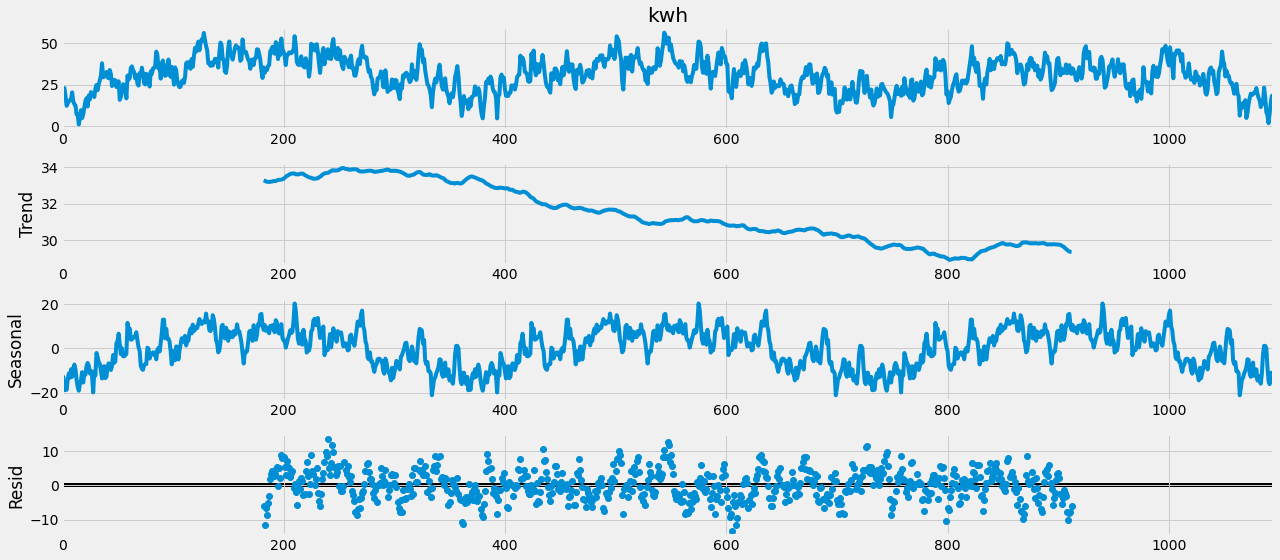

In [100]:
#decomposing into different aspects of the data 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.kwh, model='additive', period=365)
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the instability of kwh, along with its obvious seasonality, but also hint at the fact that the they are being less productive, that the pannels them selves are depreciating. 

ok so this is really interesting, cuz I wantetd ot look at two different seasons the first group of three graphs, I  used a season of 93 days, wanting to account for the changes in the seasons, so january - march, april - June, July - september, october - December. This would approximate roughly the 4 season in the year that we experience here in Utah. Using the four seasons as a season, we can see more of a sign graph, wiht a decreasing ampliutde, where if we use a full year as a season we ge an almost stricktly marginal return on the panels. In BOTH seaosns, we can see that here is a diminitioning return on the solar panal output. using the seasonality of "seasons" we see the difference of winter, spring, summer, fall, but in the year we see more of the depreciating trend 


In [9]:
'''
Plot ts with rolling mean and 95% confidence interval with rolling std.
:parameter    
  :param ts: pandas Series    
  :param window: num - for rolling stats
  :param plot_ma: bool - whether plot moving average
  :param plot_intervals: bool - whether plot upper and lower bounds
'''
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):    
    rolling_mean = ts.rolling(window=window).mean()    
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)    
    plt.title(ts.name)    
    plt.plot(ts[window:], label='Actual values', color="black")    
    if plot_ma:        
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                    color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.title("rolling average with 95% confidence interval")
    plt.grid(True)
    
    plt.show()

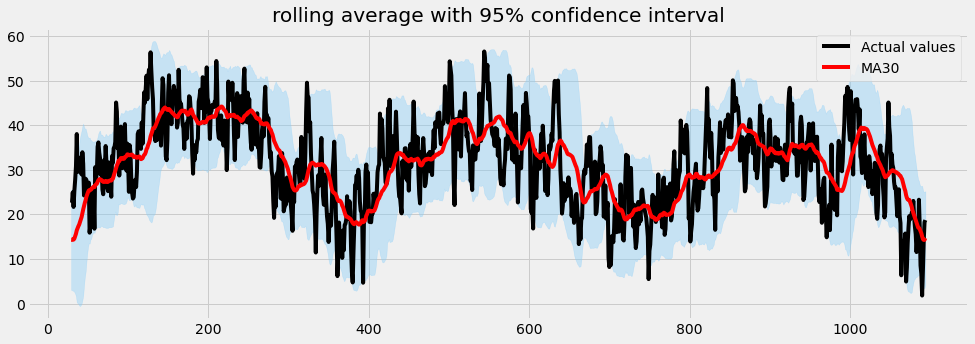

In [10]:
plot_ts(data.kwh)

###### looking at our distribution

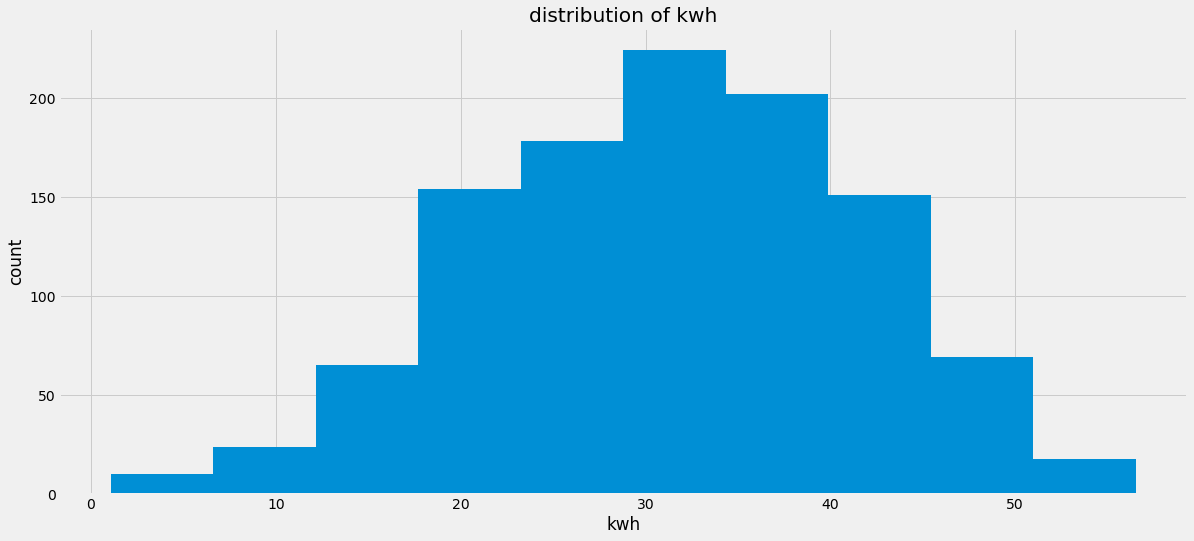

In [11]:
data.kwh.hist()
plt.title("distribution of kwh")
plt.xlabel("kwh")
plt.ylabel("count")
plt.show()

In [12]:
data = data.set_index("Date")

### Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data:

This step is parameter Selection for our furniture’s solarpannel output Time Series Model. Our goal here is to use a grid search to find the optimal set of parameters that yields the best performance for our model.

In [13]:
p = d = q = range(0, 2)
#p = [91,91,91]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 91) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 91)
SARIMAX: (0, 0, 1) x (0, 1, 0, 91)
SARIMAX: (0, 1, 0) x (0, 1, 1, 91)
SARIMAX: (0, 1, 0) x (1, 0, 0, 91)


In [15]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data.kwh,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}91 - AIC:{}'.format(param, param_seasonal, results.aic))


/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(0, 0, 0, 91)91 - AIC:10746.894679131512


/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 0, 0)x(0, 0, 1, 91)91 - AIC:9104.004235660947


/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


KeyboardInterrupt: 

In [17]:
mod = sm.tsa.statespace.SARIMAX(data.kwh,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 91),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/a13855/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7746      0.031     25.217      0.000       0.714       0.835
ma.L1         -0.9466      0.017    -55.869      0.000      -0.980      -0.913
ar.S.L91      -0.4512      0.030    -15.066      0.000      -0.510      -0.393
sigma2        33.6092      1.532     21.941      0.000      30.607      36.611


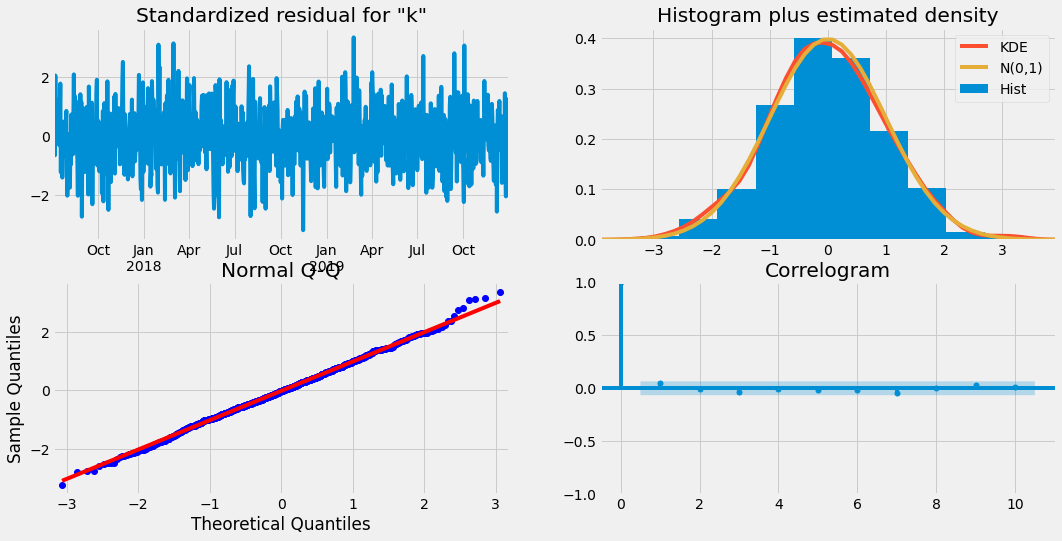

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [18]:
#pred.predicted_mean

"\npred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)\nax.fill_between(pred_ci.index,\n                pred_ci.iloc[:, 0],\n                pred_ci.iloc[:, 1], color='k', alpha=.2)\nax.set_xlabel('Date')\nax.set_ylabel('solar output')\nplt.legend()\nplt.show()"

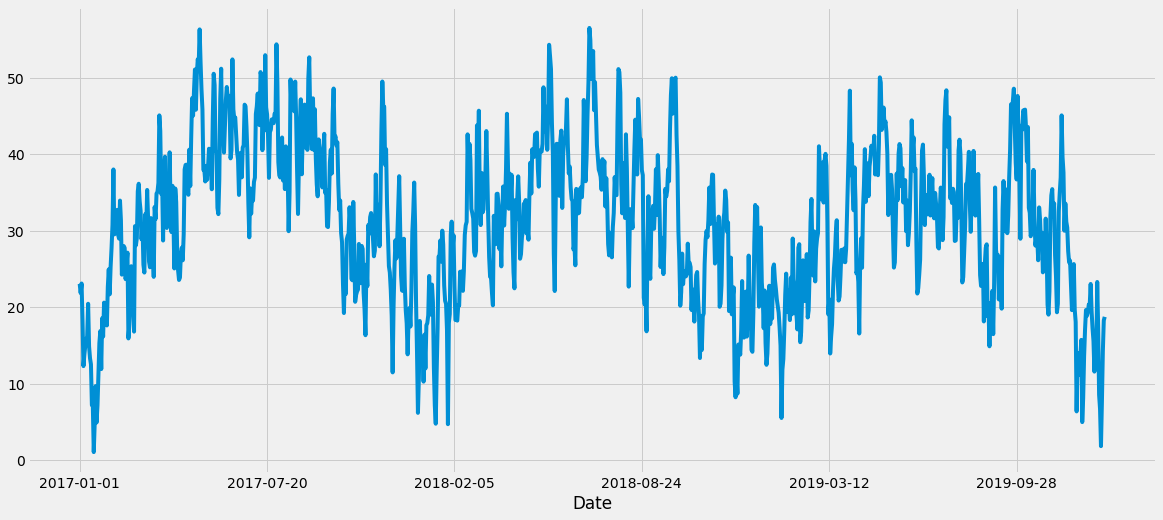

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2019-07-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = data.kwh.plot(label='observed')
'''
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('solar output')
plt.legend()
plt.show()'''

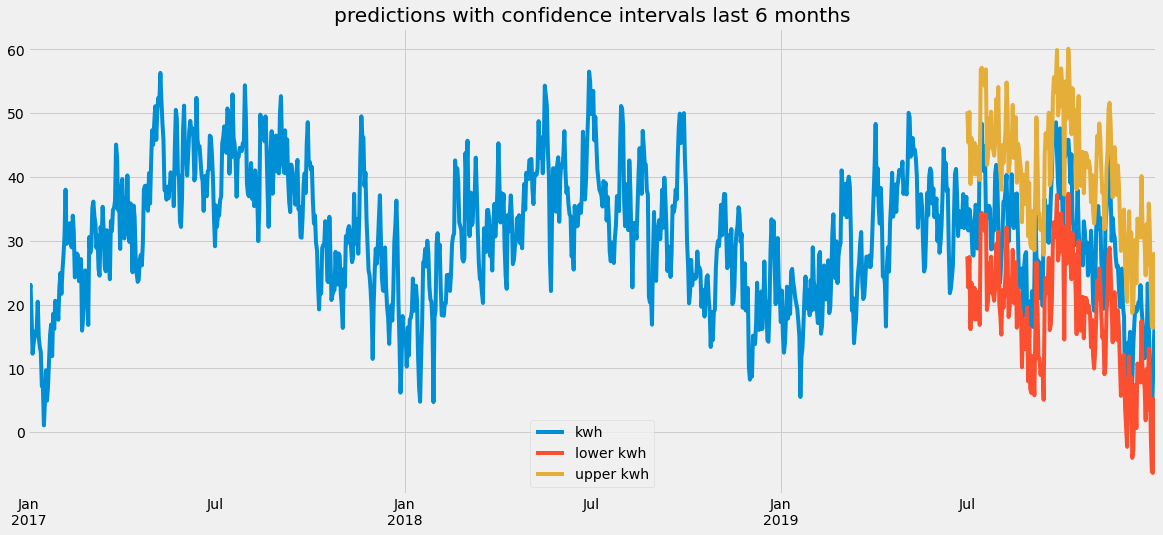

In [20]:
data.join(pred_ci, how = 'outer').plot()
plt.title("predictions with confidence intervals last 6 months")
ax.set_xlabel('Date')
ax.set_ylabel('solar output')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year and captured the seasonality toward the end of the year.


In [21]:
y_forecasted = pred.predicted_mean
y_truth = data.kwh['2019-07-01':]
mse = (((y_forecasted - y_truth) ** 2).mean())**(1/2)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 5.72


Thats pretty good, so on average, I'm off by like 5 kwh's a day. Seams pretty good 


In [108]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-01'), dynamic=False)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

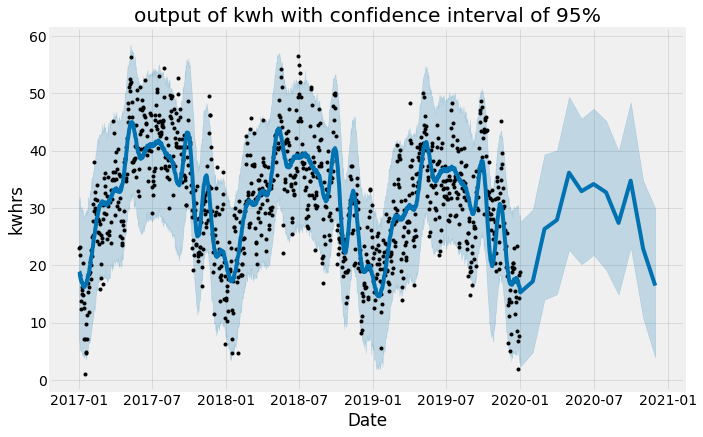

In [102]:
from fbprophet import Prophet
d2 = data.rename(columns={'dt': 'ds', 'kwh': 'y'})
model = Prophet(interval_width=0.95)
model.fit(d2)

forecast = model.make_future_dataframe(periods=12, freq='MS',                              
                                      )
forecast = model.predict(forecast)

plt.figure(figsize=(18, 6))
model.plot(forecast, xlabel = 'Date', ylabel = 'kwhrs')
plt.title('output of kwh with confidence interval of 95%');

In [113]:
model2=Prophet(interval_width=0.95, 
               yearly_seasonality=True, 
               weekly_seasonality=True, 
               #holidays=us_public_holidays,
               changepoint_prior_scale=2) 
model2.add_seasonality(name= 'monthly', 
                       period=30.5, 
                       fourier_order=5, 
                       prior_scale=0.02)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

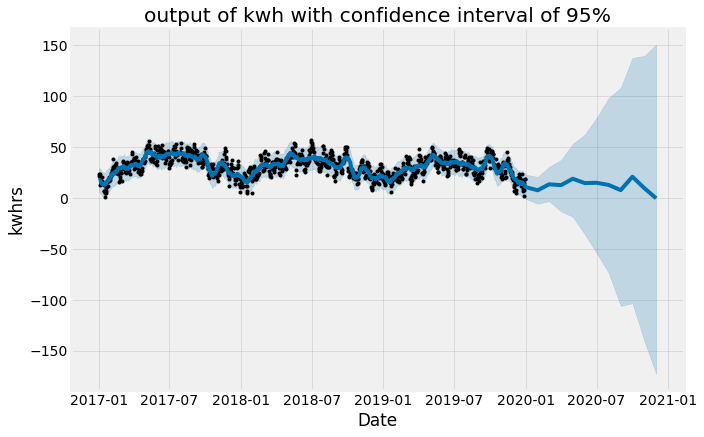

In [114]:
model2.fit(d2)
forecast2 = model2.make_future_dataframe(periods=12, freq='MS',                              
                                      )
forecast2 = model2.predict(forecast)

plt.figure(figsize=(18, 6))
model.plot(forecast2, xlabel = 'Date', ylabel = 'kwhrs')
plt.title('output of kwh with confidence interval of 95%');

In [37]:
#gonna take a look at forecast data frame -- honestly pretty cool 
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,31.706701,6.300308,32.595010,31.706701,31.706701,-12.796751,-12.796751,-12.796751,0.049850,0.049850,0.049850,-12.846601,-12.846601,-12.846601,0.0,0.0,0.0,18.909951
1,2017-01-02,31.716959,7.298750,31.023350,31.716959,31.716959,-12.917644,-12.917644,-12.917644,0.257296,0.257296,0.257296,-13.174940,-13.174940,-13.174940,0.0,0.0,0.0,18.799315
2,2017-01-03,31.727217,6.020284,31.442809,31.727217,31.727217,-13.425566,-13.425566,-13.425566,0.073683,0.073683,0.073683,-13.499250,-13.499250,-13.499250,0.0,0.0,0.0,18.301651
3,2017-01-04,31.737475,5.057222,29.964238,31.737475,31.737475,-13.985536,-13.985536,-13.985536,-0.171694,-0.171694,-0.171694,-13.813843,-13.813843,-13.813843,0.0,0.0,0.0,17.751939
4,2017-01-05,31.747733,5.272537,29.852670,31.747733,31.747733,-14.267286,-14.267286,-14.267286,-0.153963,-0.153963,-0.153963,-14.113323,-14.113323,-14.113323,0.0,0.0,0.0,17.480447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,2020-08-01,26.751627,19.728230,44.970966,26.088917,27.455118,5.959898,5.959898,5.959898,-0.136662,-0.136662,-0.136662,6.096560,6.096560,6.096560,0.0,0.0,0.0,32.711524
1103,2020-09-01,26.564692,14.388969,40.270466,25.758094,27.404688,0.822187,0.822187,0.822187,0.073683,0.073683,0.073683,0.748503,0.748503,0.748503,0.0,0.0,0.0,27.386879
1104,2020-10-01,26.383787,22.430461,47.317792,25.444129,27.385694,8.383175,8.383175,8.383175,-0.153963,-0.153963,-0.153963,8.537137,8.537137,8.537137,0.0,0.0,0.0,34.766962
1105,2020-11-01,26.196852,9.581992,35.260717,25.074527,27.340396,-3.316034,-3.316034,-3.316034,0.049850,0.049850,0.049850,-3.365884,-3.365884,-3.365884,0.0,0.0,0.0,22.880818


In [43]:
#finally looking at the second quesiton: of when do the panels lose 50% of their power generating capabilities
#lets take the average of the first year of data and then go from there: 

first_year_avg = data.kwh[:365].mean()
print(first_year_avg)

33.276986301369845


In [72]:
#ok this is our bech mark, lets look at our forcasted projectsion and see where that leaves us 
for_avg_2020 = forecast.yhat[1095:].mean()

In [73]:
# OK this is after 1 year, so now we must extrapolate out longer 
for_avg_2020

27.009863614775696

In [87]:
#five years of focasting
forecast6 = model.make_future_dataframe(periods=72, freq='MS')
forecast6 = model.predict(forecast6)
forecast6
t_25 = forecast6[1155:] 

In [88]:
t_25.yhat.mean()

16.02881371461368

In [89]:
#so it will take until 2025 or the solar panels to lose half of their yearly output - we  project 

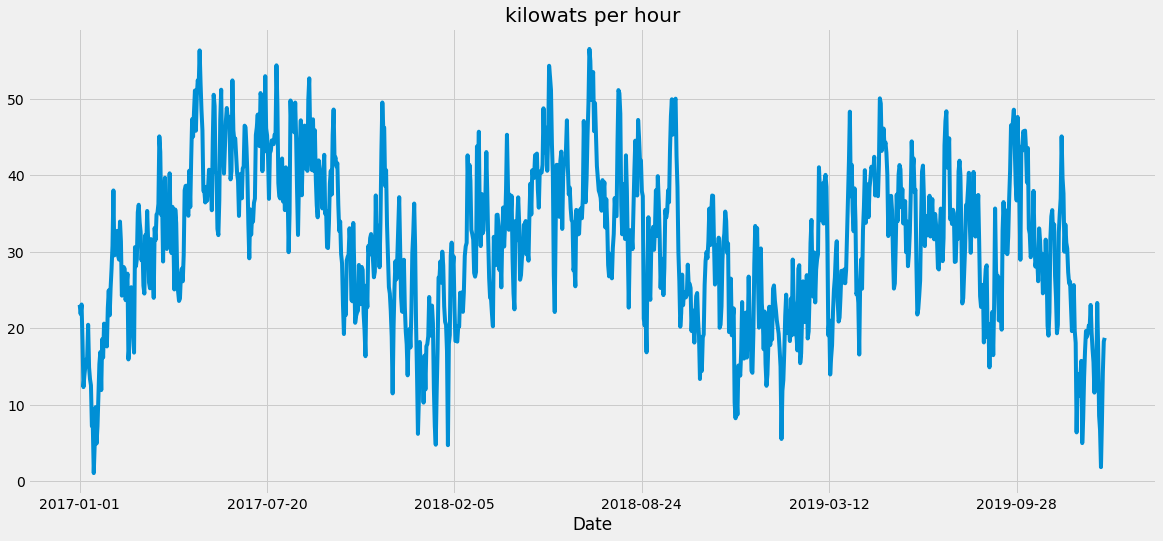

In [90]:
data.kwh.plot()
plt.title('kilowats per hour')
plt.show()